In [1]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt

In [2]:
data = yf.download(['SPY', 'GLD'], '2000-01-01')['Close'].dropna()
data[['returns_gld', 'returns_spy']] = data.pct_change()

[*********************100%***********************]  2 of 2 completed


In [3]:
data['SPY_GLD_Ratio'] = data['SPY']/data['GLD']
data['MA_20'] = data['SPY_GLD_Ratio'].rolling(window=20).mean()

In [4]:
data['Signal'] = 0
threshold = 0

data.loc[(data['SPY_GLD_Ratio'] > data['MA_20'] * (1 + threshold)), 'Signal'] = 1
data.loc[(data['SPY_GLD_Ratio'] < data['MA_20'] * (1 - threshold)), 'Signal'] = -1

In [5]:
data['Signal'] = data['Signal'].shift(1)
data = data.dropna()

transaction_cost_pct = 0
data['Strat'] = 0

In [6]:
switch_points = data['Signal'].diff().fillna(0) != 0
trade_start_points = data['Signal'].diff().fillna(0) == 1

In [7]:
data.loc[switch_points & (data['Signal'] == 1), 'Strat'] = data['returns_spy'] - transaction_cost_pct
data.loc[switch_points & (data['Signal'] == -1), 'Strat'] = data['returns_gld'] - transaction_cost_pct

data.loc[~switch_points, 'Strat'] = data['returns_spy'] * (data['Signal'] == 1) + data['returns_gld'] * (data['Signal'] == -1)

data['Strat_cumulative'] = (1 + data['Strat']).cumprod().fillna(1)
data['SPY_BH_cumulative'] = (1 + data['returns_spy']).cumprod().fillna(1)
data['GLD_BH_cumulative'] = (1 + data['returns_gld']).cumprod().fillna(1)

C:\Users\juana\AppData\Local\Temp\ipykernel_17900\24036111.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.13400807e-02  1.04025996e-02  6.34732546e-03  4.88858119e-04
  1.45123928e-03 -1.86157743e-03  1.71818682e-03 -1.83129607e-03
 -2.32409031e-03  8.03144896e-03  1.26393948e-02  1.69770994e-03
 -1.76156339e-02 -2.00064910e-03  2.99675867e-03 -2.89488400e-03
  1.58942180e-03  9.08510806e-03 -1.81613810e-03 -1.56040377e-03
  1.23643117e-02  3.56552239e-03 -1.71313833e-03 -3.37493362e-03
 -2.82641597e-03  2.84808796e-03  1.31949762e-03  4.60395279e-03
  2.84893038e-04 -4.37293781e-03 -7.97631748e-03 -4.10829645e-04
  2.84164307e-04  1.36417607e-03 -7.67678243e-04  1.11353371e-03
  1.17694659e-03  9.44100679e-03  1.72146304e-03 -1.32905681e-04
 -1.05030633e-03 -1.29184835e-04 -4.83776663e-04 -2.66138534e-03
 -2.01179548e-03  3.39752541e-04  9.05995779e-03 -1.26092168e-02
  1.02229022e-02  1.35051750e-02  1.0

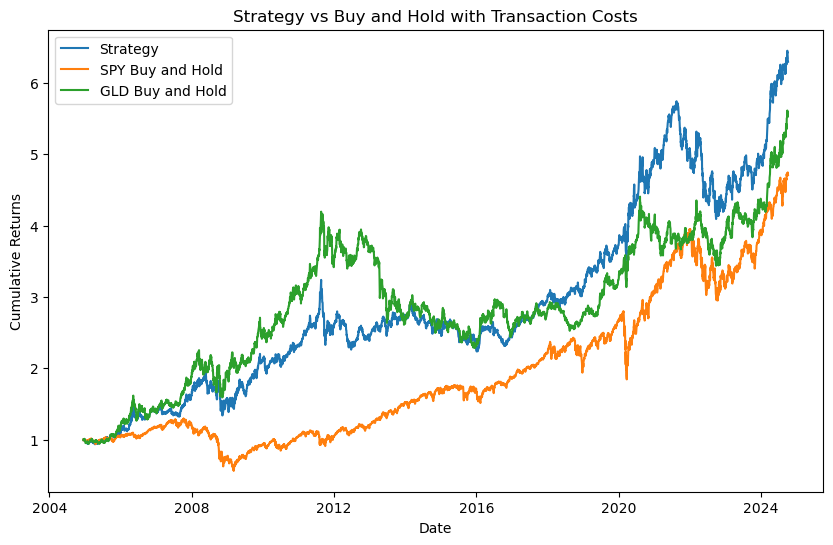

In [8]:
plt.figure(figsize=(10,6))
plt.plot(data['Strat_cumulative'], label='Strategy')
plt.plot(data['SPY_BH_cumulative'], label='SPY Buy and Hold')
plt.plot(data['GLD_BH_cumulative'], label='GLD Buy and Hold')
plt.legend()
plt.title("Strategy vs Buy and Hold with Transaction Costs")
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()